In [1]:
import os
import re
import sys
import json
import warnings
import matplotlib
import subprocess
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms

from scipy.optimize import curve_fit
from scipy.stats import percentileofscore

sys.path.append('../modules')
import plot_hurst_tfs as plt_hurst_tfs

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "olive", "gray", "cyan"]

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2023-06-08"

In [3]:
# Stock indexes
list_stock_indexes = {
    "^GSPC" : "Standard and Poor's 500", # S&P 500 (United States)
    "^DJI" : "Dow Jones Industrial Average", # Dow Jones Industrial Average (United States)
    "^W5000" : "Wilshire 5000", # Wilshire 5000 (United States)
    #"^GSPTSE" : "Toronto Stock Exchange Composite index", # S&P/TSX Composite index (Canada)
    #"^GDAXI" : "German Stock index", # DAX Performance index (Germany)
    #"^FTSE" : "Financial Times Stock Exchange 100", # FTSE 100 (United Kingdom)
    "^IBEX" : "Iberia Index 35", # Iberia Index (Spain)
    "^FCHI" : "Continuous Assisted Quotation 40", # CAC 40 (France)
    "^IXIC" : "National Association of Securities Dealers Automated Quotation Composite", # NASDAQ Composite (United States)
    #"IMOEX.ME" : "Moscow Stock Exchange", # MOEX Russia Index (Russia)
    #"^N225" : "Nikkei Heikin Kabuka Stock Exchange 225", # Nikkei 225 (Japan)
    "^STI" : "Straits Times Index 30", # STI Index (Singapore)
    "^BVSP" : "Sao Paulo Stock Exchange", # IBOVESPA (Brazil)
    "^MERV" : "Buenos Aires Stock Exchange" # MERVAL (Argentine)
}

In [4]:
# Currencies
list_currencies = {
    "KWDUSD=X" : "Currency exchange rate from Kuwaiti Dinar to U.S. dollar", # KWD/USD
    #"BHDUSD=X" : "Currency exchange rate from Bahraini Dinar to U.S. dollar", # BHD/USD
    #"OMRUSD=X" : "Currency exchange rate from Omani Rial to U.S. dollar", # OMR/USD    
    #"JODUSD=X" : "Currency exchange rate from Jordanian Dinar to U.S. dollar", # JOD/USD
    #"KYDUSD=X" : "Currency exchange rate from Cayman Islands dollar to U.S. dollar", # KYD/USD
    "GBPUSD=X" : "Currency exchange rate from U.K. pound sterling to U.S. dollar", # GBP/USD
    "CHFUSD=X" : "Currency exchange rate from swiss franc to U.S. dollar", # CHF/USD
    "EURUSD=X" : "Currency exchange rate from euro to U.S. dollar", # EUR/USD
    "SGD=X" : "Currency exchange rate from U.S. dollar to Singapore dollar", # USD/SGD
    "CAD=X" : "Currency exchange rate from U.S. dollar to Canadian dollar", # USD/CAD
    "AUD=X" : "Currency exchange rate from U.S. dollar to Australian dollar", # USD/AUD
    "NZD=X" : "Currency exchange rate from U.S. dollar to New Zealand dollar", # USD/NZD
    "MYR=X" : "Currency exchange rate from U.S. dollar to malaysian ringgit", # USD/MYR    
    "BRL=X" : "Currency exchange rate from U.S. dollar to Brazilian real", # USD/BRL    
    "CNY=X" : "Currency exchange rate from U.S. dollar to chinese renminbi", # USD/CNY
    "HKD=X" : "Currency exchange rate from U.S. dollar to Hong Kong dollar", # USD/HKD
    "SEK=X" : "Currency exchange rate from U.S. dollar to swedish krona", # USD/SEK
    "ZAR=X" : "Currency exchange rate from U.S. dollar to South African rand", # USD/ZAR
    "MXN=X" : "Currency exchange rate from U.S. dollar to mexican peso", # USD/MXN
    "THB=X" : "Currency exchange rate from U.S. dollar to thai baht", # USD/THB
    "PHP=X" : "Currency exchange rate from U.S. dollar to philippines peso", # USD/PHP
    "RUB=X" : "Currency exchange rate from U.S. dollar to russian ruble", # USD/RUB
    "INR=X" : "Currency exchange rate from U.S. dollar to indian rupee", # USD/INR
    "JPY=X" : "Currency exchange rate from U.S. dollar to japanese yen", # USD/JPY    
    "HUF=X" : "Currency exchange rate from U.S. dollar to hungarian forints", # USD/HUF
    "COP=X" : "Currency exchange rate from U.S. dollar to colombian peso", # USD/COP
    "IDR=X" : "Currency exchange rate from U.S. dollar to indonesian rupiah", # USD/IDR
    "EURCOP=X" : "Currency exchange rate from euro to colombian peso" # EUR/COP
}

## Load time series

In [5]:
df_stock_indexes = pd.read_csv("{}/df_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies = pd.read_csv("{}/df_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

df_stock_indexes_hurst = pd.read_csv("{}/df_hurst_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_hurst = pd.read_csv("{}/df_hurst_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

df_stock_indexes_tfs = pd.read_csv("{}/df_tfs_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_tfs = pd.read_csv("{}/df_tfs_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

df_stock_indexes_tts = pd.read_csv("{}/df_tts_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_tts = pd.read_csv("{}/df_tts_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

In [6]:
A = plt_hurst_tfs.prepare_data(
    df_fts = df_stock_indexes,#df_currencies,
    df_hurst = df_stock_indexes_hurst,#df_currencies_hurst,
    df_tfs = df_stock_indexes_tfs,#df_currencies_tfs,
    df_tts = df_stock_indexes_tts,#df_currencies_tts,
    interval = "days",
    threshold_n_data_hurst = 4096,
    threshold_tfs = 0.1,
    threshold_tts = 0.95,  
)
A

,date,symbol,step,cummean,cumvariance,time_series,min_date,max_date,duration,q_order,dfa_degree,hurst,p_norm_tfs,coefficient_tfs,error_coefficient_tfs,exponent_tfs,error_exponent_tfs,average_error_tfs,rsquared_tfs,p_norm_tts,coefficient_tts,error_coefficient_tts,exponent_tts,error_exponent_tts,average_error_tts,rsquared_tts
10130,1944-05-29,^GSPC,4100,0.012887,0.000208,absolute log-return,1928-01-03,2023-06-07,34854.0,-2,1,0.893418,2,0.388441,0.016571,1.743300,0.010156,0.002887,0.939239,2,0.972880,0.000426,0.133773,0.000448,0.111002,0.969715
10131,1944-05-29,^GSPC,4100,0.012887,0.000208,absolute log-return,1928-01-03,2023-06-07,34854.0,-1,1,0.896876,2,0.388441,0.016571,1.743300,0.010156,0.002887,0.939239,2,0.972880,0.000426,0.133773,0.000448,0.111002,0.969715
10133,1944-05-29,^GSPC,4100,0.012887,0.000208,absolute log-return,1928-01-03,2023-06-07,34854.0,1,1,0.866950,2,0.388441,0.016571,1.743300,0.010156,0.002887,0.939239,2,0.972880,0.000426,0.133773,0.000448,0.111002,0.969715
10134,1944-05-29,^GSPC,4100,0.012887,0.000208,absolute log-return,1928-01-03,2023-06-07,34854.0,2,1,0.827926,2,0.388441,0.016571,1.743300,0.010156,0.002887,0.939239,2,0.972880,0.000426,0.133773,0.000448,0.111002,0.969715
10135,1944-06-06,^GSPC,4105,0.012877,0.000208,absolute log-return,1928-01-03,2023-06-07,34854.0,-2,1,0.895833,2,0.387778,0.016523,1.742882,0.010143,0.002887,0.939218,2,0.972836,0.000426,0.133804,0.000448,0.111133,0.969681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85794,2017-07-11,^MERV,5090,0.140403,0.003553,log-return volatility,1996-10-09,2023-06-07,9737.0,2,1,0.727712,2,3419.484227,428.032578,6.992594,0.064023,0.009374,0.733467,2,0.993946,0.001373,0.006547,0.000948,0.052673,-14.880052
85795,2017-07-18,^MERV,5095,0.140393,0.003551,log-return volatility,1996-10-09,2023-06-07,9737.0,-2,1,0.673435,2,3427.368662,428.868802,6.993795,0.064001,0.009374,0.733444,2,0.993922,0.001366,0.006575,0.000943,0.052769,-14.674457
85796,2017-07-18,^MERV,5095,0.140393,0.003551,log-return volatility,1996-10-09,2023-06-07,9737.0,-1,1,0.683120,2,3427.368662,428.868802,6.993795,0.064001,0.009374,0.733444,2,0.993922,0.001366,0.006575,0.000943,0.052769,-14.674457
85798,2017-07-18,^MERV,5095,0.140393,0.003551,log-return volatility,1996-10-09,2023-06-07,9737.0,1,1,0.717099,2,3427.368662,428.868802,6.993795,0.064001,0.009374,0.733444,2,0.993922,0.001366,0.006575,0.000943,0.052769,-14.674457


In [7]:
A[A["rsquared_tts"] <= 1][["symbol"]].value_counts()

symbol 
^BVSP      5368
^GSPC      3696
^DJI       1600
^FCHI      1600
^GDAXI     1600
^GSPTSE    1600
^IBEX      1600
^MERV      1600
^W5000     1600
^STI       1592
^FTSE      1160
^N225      1020
^IXIC       780
dtype: int64

q_order  time_series          
-2       log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
-1       log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
 1       log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
 2       log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

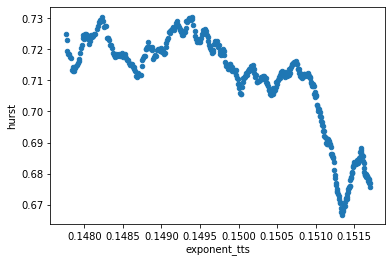

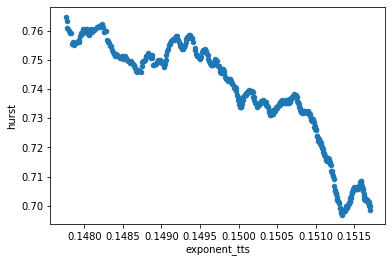

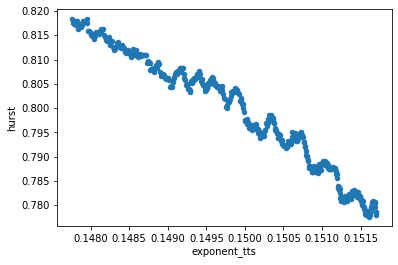

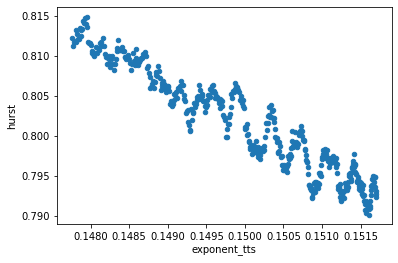

In [8]:
A[(A["symbol"] == "^GSPC") & (A["rsquared_tts"] >= 0.97)].groupby(["q_order", "time_series"]).plot(kind = "scatter", x = "exponent_tts", y = "hurst", legend = True)

q_order  time_series          
-2       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
-1       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
 1       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
 2       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

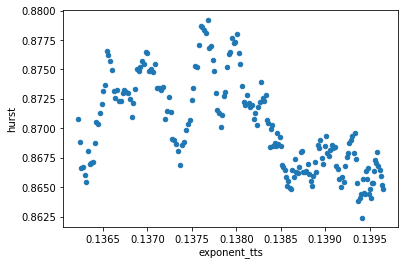

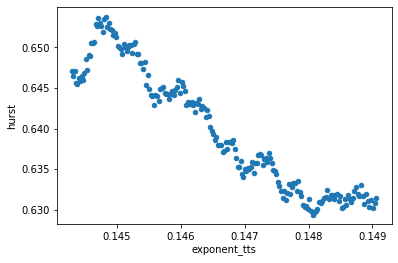

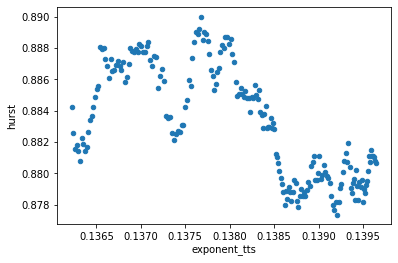

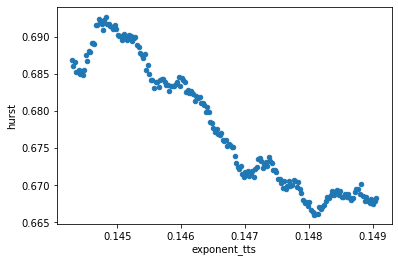

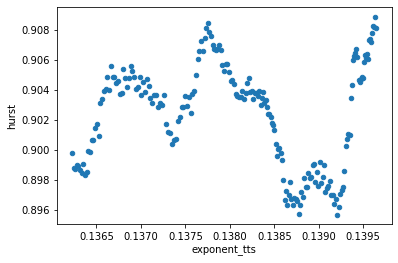

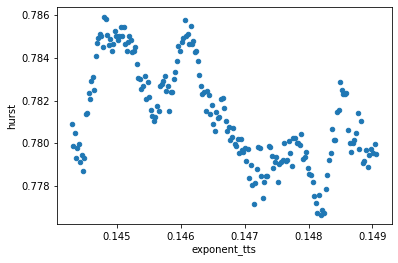

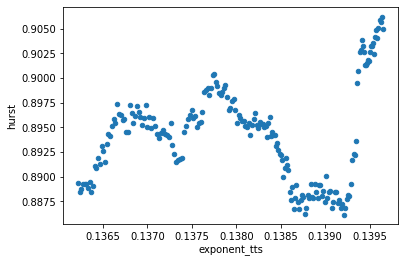

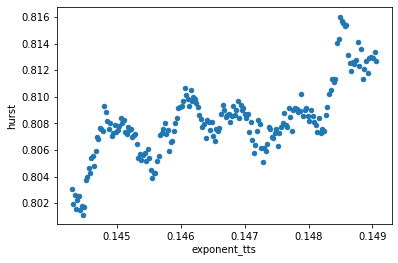

In [9]:
A[(A["symbol"] == "^IBEX") & (A["rsquared_tts"] >= 0.97)].groupby(["q_order", "time_series"]).plot(kind = "scatter", x = "exponent_tts", y = "hurst", legend = True)

q_order  time_series          
-2       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
-1       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
 1       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
 2       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

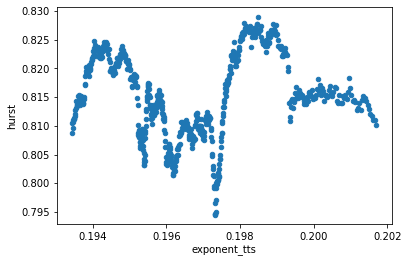

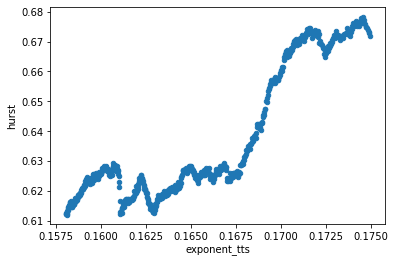

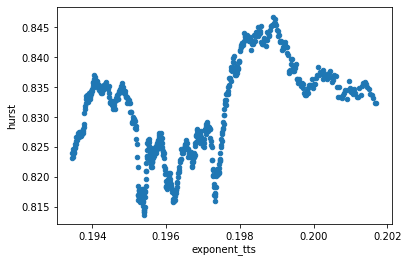

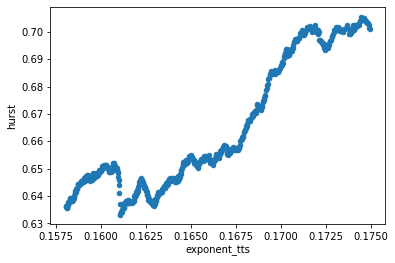

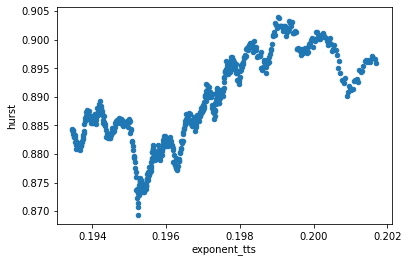

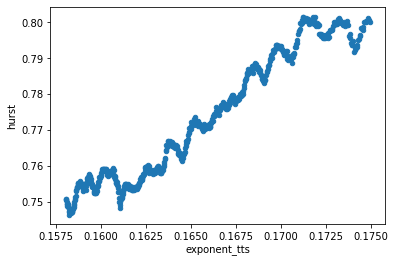

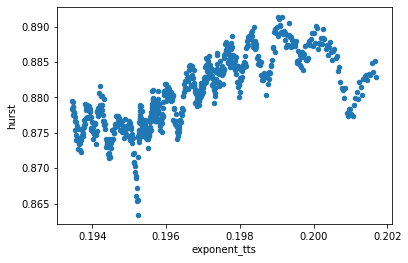

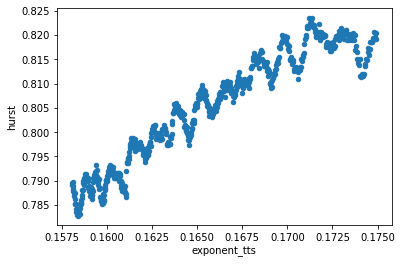

In [10]:
A[(A["symbol"] == "^BVSP") & (A["rsquared_tts"] >= 0.97)].groupby(["q_order", "time_series"]).plot(kind = "scatter", x = "exponent_tts", y = "hurst", legend = True)

q_order  time_series          
2        absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

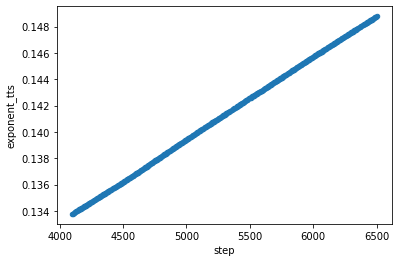

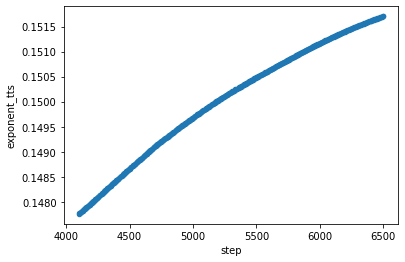

In [11]:
A[((A["symbol"] == "^GSPC") & (A["q_order"] == 2))].groupby(["q_order", "time_series"]).plot(kind = "scatter", x = "step", y = "exponent_tts", legend = True)

q_order  time_series          
-2       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
-1       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
 1       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
 2       absolute log-return      AxesSubplot(0.125,0.125;0.775x0.755)
         log-return volatility    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

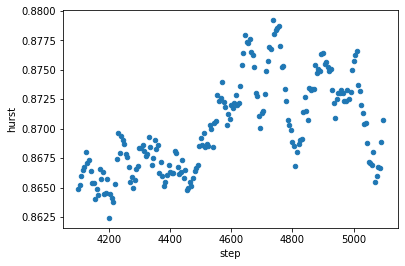

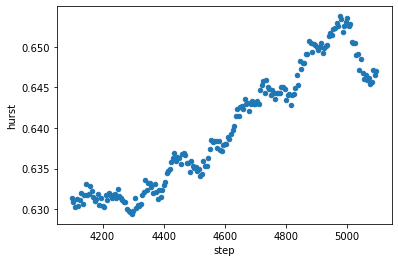

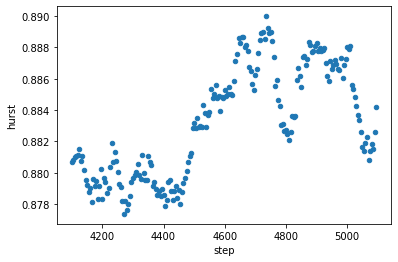

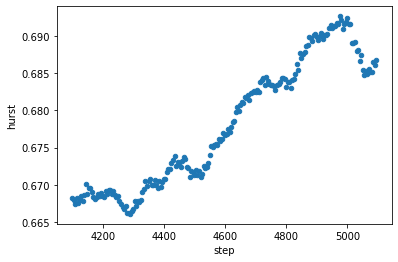

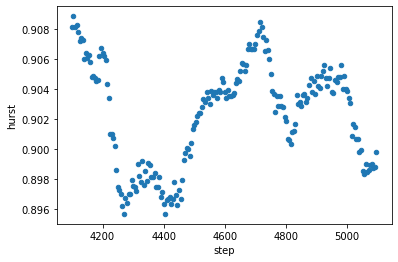

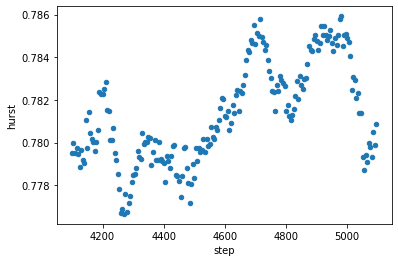

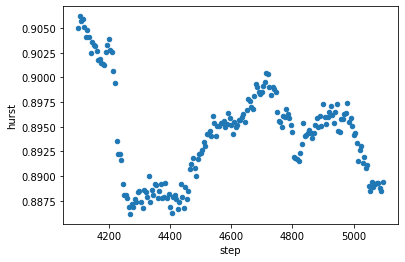

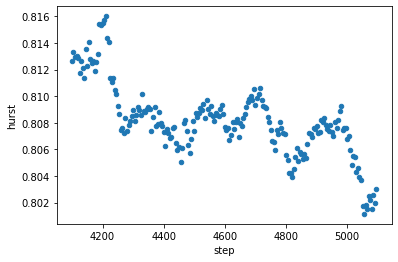

In [12]:
A[A["symbol"] == "^IBEX"].groupby(["q_order", "time_series"]).plot(kind = "scatter", x = "step", y = "hurst", legend = True)